# Convolutional Neural Networks - Deep Learning

# Task Description

Each student should take at least 10 photos from 3 different categories: cup, keyboard, book.

1. Create a shared database of photos. Normalize the format of all the images and place them in separate directories for each category.

2. Propose a convolutional neural network (CNN) and train it to recognize the objects.

3. Augment the database using data augmentation techniques. Train the network on the augmented dataset. Compare the results.

Please use the ImageDataGenerator class for data creation and augmentation.

# Opis zadania
1. Każdy student powinien zrobić co najmniej 10 zdjęć z 3 różnych kategorii: kubek, klawiatura, książka,

2. Należy stworzyć wspólną bazę zdjęć. Należy znormalizować format wszystkich zdjęć oraz umieścić w osobnych katalogach dla każdej kategorii,

3. Zaproponuj splotową sieć neuronową i naucz ją rozpoznawać obiekty,

4. Zwiększ bazę danych za pomocą technik augmentacji. Naucz sieć na rozszerzonym zbiorze danych. Porównaj wyniki.

Proszę użyć klasy ImageDataGenerator do tworzenia i augmentacji danych

In [26]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [9]:
base_dir = 'pics'
output_dir = 'augmented_images'
os.makedirs(output_dir, exist_ok=True)

categories = ['book', 'cup', 'keyboard']
num_augmented_images_per_category = 250

for category in categories:
    category_path = os.path.join(base_dir, category)
    image_files = os.listdir(category_path)

    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    num_images_per_file = num_augmented_images_per_category // len(image_files)

    for image_file in image_files:
        img = load_img(os.path.join(category_path, image_file))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_category_dir, save_prefix='aug',
                                  save_format='jpeg'):
            i += 1
            if i >= num_images_per_file:
                break

In [13]:
# Wczytywanie danych przed augmentacją
pre_augmentation_data = []
pre_augmentation_labels = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    image_files = os.listdir(category_path)

    for image_file in image_files:
        img = load_img(os.path.join(category_path, image_file), target_size=(500, 500))
        x = img_to_array(img) / 255.0
        pre_augmentation_data.append(x)
        pre_augmentation_labels.append(category)

pre_augmentation_data = np.array(pre_augmentation_data)
pre_augmentation_labels = np.array(pre_augmentation_labels)

In [14]:
# Wczytywanie danych po augmentacji
post_augmentation_data = []
post_augmentation_labels = []

for category in categories:
    category_path = os.path.join(output_dir, category)
    image_files = os.listdir(category_path)

    for image_file in image_files:
        img = load_img(os.path.join(category_path, image_file), target_size=(500, 500))
        x = img_to_array(img) / 255.0
        post_augmentation_data.append(x)
        post_augmentation_labels.append(category)

post_augmentation_data = np.array(post_augmentation_data)
post_augmentation_labels = np.array(post_augmentation_labels)

In [16]:
print("Przed augmentacją:")
print("Liczba zdjęć:", len(pre_augmentation_data))
print("Liczba etykiet:", len(pre_augmentation_labels))
print("Kategorie:", categories)
print()

print("Po augmentacji:")
print("Liczba zdjęć:", len(post_augmentation_data))
print("Liczba etykiet:", len(post_augmentation_labels))
print("Kategorie:", categories)
print()

Przed augmentacją:
Liczba zdjęć: 60
Liczba etykiet: 60
Kategorie: ['book', 'cup', 'keyboard']

Po augmentacji:
Liczba zdjęć: 719
Liczba etykiet: 719
Kategorie: ['book', 'cup', 'keyboard']



In [19]:
num_classes = len(categories)

# Przekształcenie etykiet kategorii na wartości numeryczne
label_encoder = LabelEncoder()
pre_augmentation_labels_encoded = label_encoder.fit_transform(pre_augmentation_labels)
post_augmentation_labels_encoded = label_encoder.transform(post_augmentation_labels)

# Przekształcenie wartości numerycznych na one-hot encoding
pre_augmentation_labels_encoded = to_categorical(pre_augmentation_labels_encoded, num_classes=num_classes)
post_augmentation_labels_encoded = to_categorical(post_augmentation_labels_encoded, num_classes=num_classes)


In [20]:
pre_augmentation_data_train, pre_augmentation_data_test, pre_augmentation_labels_train, pre_augmentation_labels_test = train_test_split(
    pre_augmentation_data, pre_augmentation_labels_encoded, test_size=0.2, random_state=1)

post_augmentation_data_train, post_augmentation_data_test, post_augmentation_labels_train, post_augmentation_labels_test = train_test_split(
    post_augmentation_data, post_augmentation_labels_encoded, test_size=0.2, random_state=1)

In [21]:
# Tworzenie modelu
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [22]:
# Uczenie modelu przed augmentacją
pre_augmentation_history = model.fit(pre_augmentation_data_train, pre_augmentation_labels_train, epochs=20,
                                     batch_size=32,
                                     validation_data=(pre_augmentation_data_test, pre_augmentation_labels_test))

Epoch 1/20
2/2 [==============================] - 27s 6s/step - loss: 2.3195 - accuracy: 0.3333 - val_loss: 1.4317 - val_accuracy: 0.5000
Epoch 2/20
2/2 [==============================] - 17s 6s/step - loss: 2.3444 - accuracy: 0.3542 - val_loss: 1.4762 - val_accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 10s 5s/step - loss: 1.3853 - accuracy: 0.4792 - val_loss: 2.2379 - val_accuracy: 0.0833
Epoch 4/20
2/2 [==============================] - 9s 4s/step - loss: 1.7717 - accuracy: 0.4583 - val_loss: 2.0724 - val_accuracy: 0.1667
Epoch 5/20
2/2 [==============================] - 8s 3s/step - loss: 1.4448 - accuracy: 0.4792 - val_loss: 1.0711 - val_accuracy: 0.5833
Epoch 6/20
2/2 [==============================] - 8s 3s/step - loss: 0.6379 - accuracy: 0.7292 - val_loss: 0.9279 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 8s 3s/step - loss: 0.6377 - accuracy: 0.6667 - val_loss: 1.0480 - val_accuracy: 0.5000
Epoch 8/20
2/2 [======================

In [23]:
# Uczenie modelu po augmentacji
post_augmentation_history = model.fit(post_augmentation_data_train, post_augmentation_labels_train, epochs=20,
                                      batch_size=32,
                                      validation_data=(post_augmentation_data_test, post_augmentation_labels_test))


Epoch 1/20
18/18 [==============================] - 106s 6s/step - loss: 0.7434 - accuracy: 0.6817 - val_loss: 0.6509 - val_accuracy: 0.7083
Epoch 2/20
18/18 [==============================] - 87s 5s/step - loss: 0.5036 - accuracy: 0.8000 - val_loss: 0.4981 - val_accuracy: 0.8194
Epoch 3/20
18/18 [==============================] - 85s 5s/step - loss: 0.3160 - accuracy: 0.8817 - val_loss: 0.4467 - val_accuracy: 0.8264
Epoch 4/20
18/18 [==============================] - 88s 5s/step - loss: 0.2453 - accuracy: 0.9217 - val_loss: 0.3783 - val_accuracy: 0.8542
Epoch 5/20
18/18 [==============================] - 84s 5s/step - loss: 0.1898 - accuracy: 0.9461 - val_loss: 0.3750 - val_accuracy: 0.8403
Epoch 6/20
18/18 [==============================] - 82s 5s/step - loss: 0.1226 - accuracy: 0.9739 - val_loss: 0.3588 - val_accuracy: 0.8333
Epoch 7/20
18/18 [==============================] - 85s 5s/step - loss: 0.0896 - accuracy: 0.9843 - val_loss: 0.3440 - val_accuracy: 0.8681
Epoch 8/20
18/18 [=

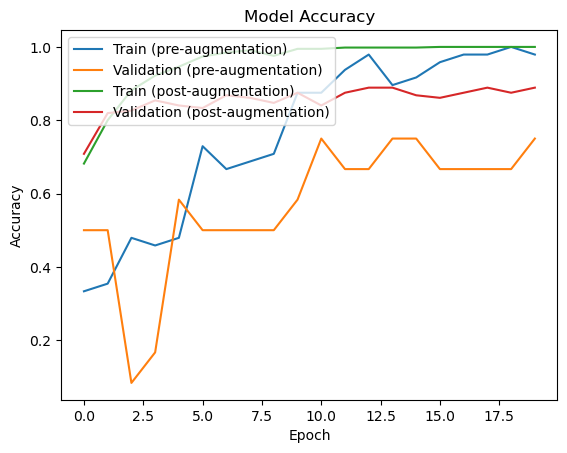

In [24]:
plt.plot(pre_augmentation_history.history['accuracy'])
plt.plot(pre_augmentation_history.history['val_accuracy'])
plt.plot(post_augmentation_history.history['accuracy'])
plt.plot(post_augmentation_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (pre-augmentation)', 'Validation (pre-augmentation)', 'Train (post-augmentation)',
            'Validation (post-augmentation)'], loc='upper left')
plt.show()

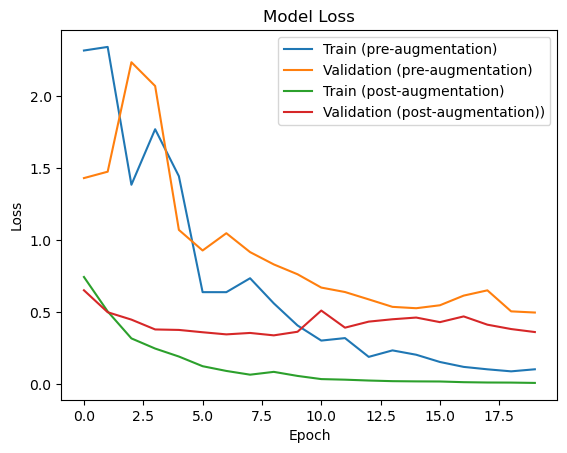

In [25]:
plt.plot(pre_augmentation_history.history['loss'])
plt.plot(pre_augmentation_history.history['val_loss'])
plt.plot(post_augmentation_history.history['loss'])
plt.plot(post_augmentation_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (pre-augmentation)', 'Validation (pre-augmentation)', 'Train (post-augmentation)',
            'Validation (post-augmentation))'], loc='upper right')
plt.show()